In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# FOLDERNAME = 'ex3_302168687_200409159'
sys.path.append('/content/drive/MyDrive')
# sys.path.append('/content/drive/My Drive/{}/Q4'.format(FOLDERNAME))
%cd /content/drive/MyDrive

# %load_ext autoreload
# %autoreload 2

Mounted at /content/drive/
/content/drive/MyDrive


# Imports

In [2]:
# !pip install torch # ==1.7.1+cu101
!pip install torchaudio==0.7.2
!pip install torchvision==0.8.2
!pip install soundfile

     |████████████████████████████████| 7.6MB 8.2MB/s 


In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchaudio

import os
import matplotlib
import pylab
import librosa
import numpy as np

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio

from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 

import os
import pandas as pd
import random
import pdb

from pathlib import Path

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Model architecture


In [4]:
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

In [5]:
gbp_relu = GuidedBackpropReLU()

class MonoCnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(MonoCnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        # self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        # self.C22 = nn.Conv2d(64,64,3,padding=1)
        # self.C3 = nn.Conv2d(64,128,3,padding=1)
        # self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool_1 = nn.MaxPool2d(2,2)
        self.maxpool_2 = nn.MaxPool2d(2,2)
        # self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)  

        self.activations_1 = gbp_relu.apply # nn.ReLU()
        self.activations_2 = gbp_relu.apply # nn.ReLU() 
        
        self.fc1 = nn.Linear(64*32*32,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features + 1,self.num_classes) 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x,timestamp):
        # add sequence of convolutional and max pooling layers
        x = self.activations_1(self.BN1(self.C1(x)))
        x = self.maxpool_1(x)
        #x = self.maxpool1(F.relu(self.BN11(self.C11(x))))
        x = self.activations_2(self.BN2(self.C2(x)))
        x = self.maxpool_2(x)
        #x = self.maxpool1(F.relu(self.BN22(self.C22(x))))
        #x = F.relu(self.BN3(self.C3(x)))
        #x = self.maxpool1(F.relu(self.BN33(self.C33(x))))
        # flatten image input
        x = x.view(-1,64*32*32)
        x = self.BNFC(self.fc1(x))
        x = self.dropout(x)
        x = torch.cat((x, timestamp/240), 1) #normalize timestamp
        x = self.fc2(x)
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        

# Utility functions

In [6]:
def plotData(S, sr=44100, hop_length=512):
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');

def saveDataAsImage(S, save_path):
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()


#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio
import copy


def loadRec(wavPath):
    sound, sample_rate = torchaudio.load(wavPath)
    print("sample_rate", sample_rate)
    return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    map_location=None if torch.cuda.is_available() else torch.device('cpu')
    state_dict = torch.load(path, map_location)
    
    temp_dict = copy.copy(state_dict)
    for key in temp_dict.keys():
      if key.split('.')[0] not in dir(model):
        del state_dict[key]

    model.load_state_dict(state_dict)
    return model

@torch.no_grad()
def calculateTestLoss(model, criterion, test_generator):
    model.eval()
    test_loss = 0.
    for dataBatch,target,timestamp in test_generator:
        dataBatch, target, timestamp = dataBatch.unsqueeze(1).float().cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()
        output = model(dataBatch, timestamp)
        loss = criterion(output,torch.max(target.long(), 1)[1])
        test_loss += loss.item()*dataBatch.size(0)

    return test_loss/len(test_generator)

# Dataset

In [7]:
class Dataset(data.Dataset):
    def __init__(self, fileNames, labels, dataPath, numClasses):
        'Initialization'

        self.labels = labels
        self.file_names = fileNames
        self.data_path = dataPath
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        label = self.labels[index]
        file = os.path.join(self.data_path, str(label), str(file_name))
        Im = torch.load(file)
        label_out = np.zeros(self.num_classes)
        label_out[label-2] = 1
        label_out = torch.from_numpy(label_out).float()
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])/1000 # quantization of 30-minutes
        timestamp = torch.tensor(timestamp, dtype=torch.float32)
        #print(timestamp, Im.shape, label)

        return Im, label_out, timestamp, file_name

Select criterion and optimizer and load model

In [8]:
train_on_gpu=torch.cuda.is_available()
num_classes = 10
model = MonoCnnAudioNet(num_classes)
model_name= "MonoCnnAudioNet"
if(train_on_gpu): 
    model.cuda()
print(model)
# pos_weight = torch.ones([num_classes]).cuda() * num_classes
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
criterion = nn.CrossEntropyLoss()

MonoCnnAudioNet(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN33): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BNFC): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax(dim=1

Load dataset

In [ ]:
path = "Project/Dataset"
test_path = "Project/TestSet"
test_csv_path = "project_new/copy_itan/TestSet"
control_group_path = "Testset/validation"

#Load train data
labels = pd.read_csv(os.path.join(path, "labels.csv"))

# labels = labels[labels['label']==11]

n_samples = len(labels)
train_len = int(n_samples * 0.9)
valid_len = n_samples - train_len
test_len  = n_samples - train_len - valid_len
total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)

test_labels = pd.read_csv(os.path.join(test_csv_path, "labels.csv"))
test_len = len(test_labels)
test_list=list(range(test_len))

control_labels = pd.read_csv(os.path.join(control_group_path, "test_labels.csv"))
control_len = len(control_labels)
control_list = list(range(control_len))

train_data = labels.iloc[train_list]
valid_data = labels.iloc[valid_list]
test_data = test_labels.iloc[test_list]
control_data = control_labels.iloc[control_list]

path = os.path.join(path, "Mono")
test_path = os.path.join(test_path, "Mono")
control_path = os.path.join(control_group_path, "Mono")

training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), path, num_classes)
batch_size = 32
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)

#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), path, num_classes)
batch_size = 32
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)

#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), test_path, num_classes)
batch_size = 32
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

#Load control data
control_set = Dataset(control_data["filename"].tolist(), control_data["label"].tolist(), control_path, num_classes)
control_batch_size = 8
control_params = {'batch_size': control_batch_size,
          'shuffle': True,
          'num_workers': 6}
control_generator = data.DataLoader(control_set, **control_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")
print("Control set contains " + str(control_len) + " samples")

ytick_locs = [0, 31, 63, 95, 127] 
freq_ticks = [0, 1, 2.7, 7.3, 22]

xtick_locs = [0,100,200]
time_ticks = [0,15,30]

adjusted_extent = [0, 200, 0, 128]

Training set contains 36000 samples
Validation set contains 4000 samples
Test set contains 5000 samples
Control set contains 16 samples


# Grad-CAM

In [ ]:
%pdb off

# print("\n***Only spot 2 used***\n")

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter, zoom

num_batches = 6
num_classes = 10
# layers_for_maps = ['activations_1', 'maxpool_1', 'activations_2', 'maxpool_2']
# layers_for_maps = ['C1', 'C2']
layers_for_maps = []

eps = 1e-7

model_name = "MonoCnnAudioNet"
model = MonoCnnAudioNet(num_classes)
model = loadModel(model, model_name, "Project/Models/Mono/")

start_time = time.time()
#Warnings.filterwarnings('ignore')

def get_feture_map(name):
    def hook(model, input, output):
        # feature_maps[name] = input[0].detach()
        feature_maps[name] = output.detach()
    return hook

def get_grad_map(name):
    def hook(model, grad_input, grad_output):
        # grad_maps[name] = grad_input[0].detach()
        grad_maps[name] = grad_output[0].detach()
    return hook

for layer in layers_for_maps:
  getattr(model, layer).register_forward_hook(get_feture_map(layer))
  getattr(model, layer).register_backward_hook(get_grad_map(layer))

# layers_for_maps = ['input'] + layers_for_maps

if train_on_gpu: 
  model.cuda()

for batch_idx, (dataBatch, target, extra_feature, file_name) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  feature_maps  = dict()
  grad_maps     = dict()
  grad_cam_imgs = dict()

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda() #dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()
  model.zero_grad()

  dataBatch.requires_grad_()

  output = model(dataBatch, extra_feature)

  # # calculate the batch loss
  # if not time_test:
  #   loss = criterion(output,torch.max(target.long(), 1)[1])
  # else:
  #   loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

  one_hot = torch.zeros(output.shape)
  one_hot[target.bool()] = 1
  if train_on_gpu: 
    one_hot = one_hot.cuda()
  true_class_score = torch.sum(one_hot * output)

  true_class_score.backward()

  # compute grad-cam maps for each layer
  for layer, grads in grad_maps.items():
    channel_weights = grads.mean((-2,-1), keepdims=True)
    grad_cam = (channel_weights * feature_maps[layer]).sum(-3)
    # grad_cam[grad_cam<0] = 0 
    grad_cam_imgs[layer] = grad_cam

  # get input spectrogram saliency map
  input_saliency_maps = dataBatch.grad.data.abs()
  # grad_maps['input']  = input_saliency_maps


  plt.figure(figsize=(30, 30/8))
  for i_map in range(6): # first 8 in batch
      plt.subplot(1, 6, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach().cpu()
      plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
      # plt.axis("off")
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
      true_label = torch.nonzero(target[i_map].squeeze()).item()
      plt.title(str(true_label+2)+'\n'+file_name[i_map].split('.')[0])
  plt.show()

  print('\n')

  for num_layer, layer in enumerate(layers_for_maps):
      print(f"Grad-CAM maps for layer {layer}:\n")
      plt.figure(figsize=(30, 30/8))
      for i_sample in range(6):
        grad_cam_img = grad_cam_imgs[layer][i_sample,...].squeeze().cpu().numpy()
        grad_cam_img = zoom(grad_cam_img, 128/grad_cam_img.shape[-1])
        plt.subplot(1, 6, i_sample + 1)
        plt.imshow(grad_cam_img, cmap='gray', origin='lower', extent = adjusted_extent)
        plt.yticks(ytick_locs,freq_ticks)
        plt.xticks(xtick_locs,time_ticks)
        plt.xlabel('time (sec)')
        plt.ylabel('freq (kHz)')
        # plt.axis("off")

      plt.show()

      print('\n')

  print("Class scores")
  plt.figure(figsize=(30, 30/8))
  for i_map in range(6): # first 8 in batch
      plt.subplot(1, 6, i_map + 1)
      scores = output[i_map,...].squeeze().detach().cpu()
      true_label = torch.nonzero(target[i_map].squeeze()).item()
      bar_colors = ['b']*10
      bar_colors[true_label] = 'r'
      plt.bar(np.arange(2,12),scores, color=bar_colors)
      plt.grid()
      plt.xticks(np.arange(2,12))
      plt.title(f'True label = {true_label+2}')
      # plt.axis("off")
  plt.show()

  print('\n\n\n\n')


Output hidden; open in https://colab.research.google.com to view.

# Control data classification

Automatic pdb calling has been turned OFF


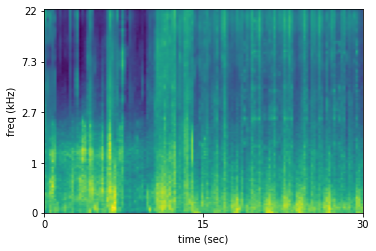

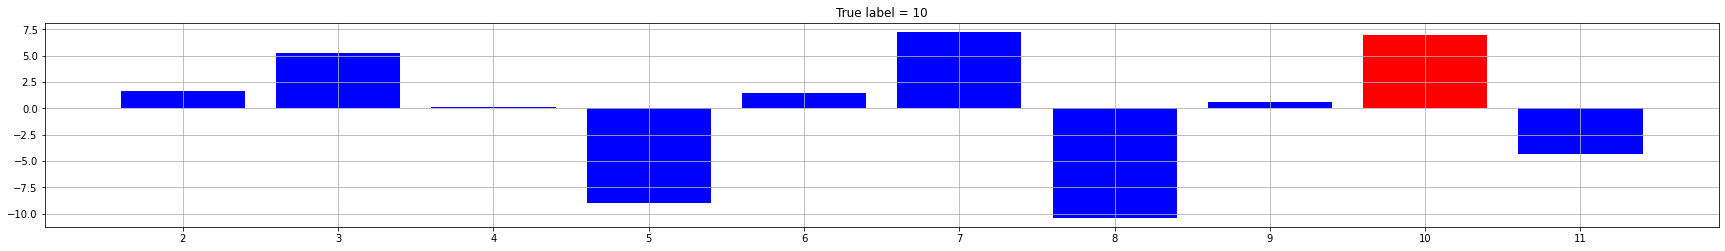

In [ ]:
%pdb off

# print("\n***Only spot 2 used***\n")

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter, zoom

num_batches = 20
num_classes = 10

eps = 1e-7

if train_on_gpu: 
  model.cuda()

model_name = "MonoCnnAudioNet"
model = MonoCnnAudioNet(num_classes)
model = loadModel(model, model_name, "Project/Models/Mono/")

error_spectograms = None
error_scores = None

for batch_idx, (dataBatch, target, extra_feature, file_name) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()
  model.zero_grad()

  output = model(dataBatch, extra_feature)
  output_probs = F.softmax(output.squeeze(),1)

  for i_sample in range(dataBatch.shape[0]):
    true_label = torch.argmax(target[i_sample].squeeze()).item()
    prediction = torch.argmax(output[i_sample].squeeze()).item()
    if true_label != prediction:
      if error_spectograms is None:
        error_spectograms = dataBatch[i_sample].unsqueeze(0)
        error_scores      = output[i_sample].unsqueeze(0)
      else:
        error_spectograms = torch.cat((error_spectograms, dataBatch[i_sample].unsqueeze(0)))
        error_scores      = torch.cat((error_scores, output[i_sample].unsqueeze(0)))
    
  if error_spectograms is not None and error_spectograms.shape[0] >= 8:
    break

num_error_samples = error_spectograms.shape[0]

plt.figure(figsize=(30, 30/8))
for i_map in range(num_error_samples): # first 8 in batch
    plt.subplot(1, num_error_samples, i_map + 1)
    spectrogram = error_spectograms[i_map,...].squeeze().detach().cpu()
    plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
    plt.yticks(ytick_locs,freq_ticks)
    plt.xticks(xtick_locs,time_ticks)
    plt.xlabel('time (sec)')
    plt.ylabel('freq (kHz)')
    # plt.axis("off")
plt.show()

print('\n\n\n\n')
plt.figure(figsize=(30, 30/8))
for i_map in range(num_error_samples): # first 8 in batch
    plt.subplot(1, num_error_samples, i_map + 1)
    scores = error_scores[i_map,...].squeeze().detach().cpu()
    true_label = torch.nonzero(target[i_map].squeeze()).item()
    bar_colors = ['b']*10
    bar_colors[true_label] = 'r'
    plt.bar(np.arange(2,12),scores, color=bar_colors)
    plt.grid()
    plt.xticks(np.arange(2,12))
    plt.title(f'True label = {true_label+2}')
    # plt.axis("off")
plt.show() 

print('\n\n\n\n')


# Occlusion maps

In [ ]:
%pdb off

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pdb

num_batches = 1
occlusion_hight = 21
occlusion_width = 21
num_classes = 10

mono_model_name = "MonoCnnAudioNet"
mono_model = MonoCnnAudioNet(num_classes)
mono_model = loadModel(mono_model, mono_model_name, "Project/Models/Mono/")

model.eval()
with torch.no_grad():

  for batch_idx, (dataBatch, target, extra_feature, file_name) in enumerate(valid_generator):
    if batch_idx >= num_batches:
      break

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
    else:
      dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

    occlusion_maps_out  = torch.zeros(dataBatch.shape)
    # occlusion_maps_loss = torch.zeros(dataBatch.shape)
    
    batch_mean_per_image = dataBatch.mean((-1,-2)).view(batch_size,1,1,1)
    image_hight = dataBatch.shape[-2]
    image_width = dataBatch.shape[-1]
    h_margin = occlusion_hight//2
    w_margin = occlusion_width//2
    for row in tqdm(range(h_margin, image_hight-h_margin)):
      for col in range(w_margin, image_width-w_margin):

        ocl_batch = dataBatch.clone().detach()

        # replace occluded patch with image means
        ocl_batch[..., row-h_margin:row+h_margin+1, col-w_margin:col+w_margin+1] = batch_mean_per_image

        # pass data through model
        output = model(ocl_batch, extra_feature)

        # per image loss
        # loss = (output - target)**2

        # x = (output - target).abs()
        # y = 1440 - (output - target).abs()

        # train_acc = (torch.min(x,y)<=240).float()

        occlusion_maps_out[..., row, col] = output[target.bool()].unsqueeze(1)
        # occlusion_maps_loss[..., row, col] = loss

    min_per_map = occlusion_maps_out[..., h_margin:-h_margin, w_margin:-w_margin].amin((-1,-2)).view(batch_size,1,1,1)

    # set boundry values to min non-oundry value per image
    occlusion_maps_out[..., :h_margin, :]  = min_per_map
    occlusion_maps_out[..., -h_margin:, :] = min_per_map
    occlusion_maps_out[..., :, :w_margin]  = min_per_map
    occlusion_maps_out[..., :, -w_margin:] = min_per_map

    for i_row in range(4):

      print('\n\n\n')
      plt.figure(figsize=(40, 40))
      for i_map in range(6): # dataBatch.shape[0]):
          plt.subplot(1, 6, i_map + 1)
          spectrogram = dataBatch[8*i_row+i_map,...].squeeze().cpu()
          plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
          plt.yticks(ytick_locs,freq_ticks)
          plt.xticks(xtick_locs,time_ticks)
          plt.xlabel('time (sec)')
          plt.ylabel('freq (kHz)')
          # plt.axis("off")
      plt.show()

      print('\n')
      plt.figure(figsize=(40, 40))
      for i_map in range(6): # dataBatch.shape[0]):
          plt.subplot(1, 6, i_map + 1)
          out_map = occlusion_maps_out[8*i_row+i_map,...].squeeze().cpu()
          plt.imshow(out_map, cmap='gray', origin='lower', extent = adjusted_extent)
          plt.yticks(ytick_locs,freq_ticks)
          plt.xticks(xtick_locs,time_ticks)
          plt.xlabel('time (sec)')
          plt.ylabel('freq (kHz)')
          # plt.axis("off")
      plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Load pretrained model and extract feature maps

reference: https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [ ]:
%pdb off

import matplotlib.pyplot as plt

num_samples = 1

num_classes = 10

mono_model_name = "MonoCnnAudioNet"
mono_model = MonoCnnAudioNet(num_classes)
mono_model = loadModel(mono_model, mono_model_name, "Project/Models/Mono/")

for batch_idx, (dataBatch, target, extra_feature) in enumerate(training_generator):
  if batch_idx >= num_samples:
    break
# for batch_idx, (dataBatch, target, extra_feature) in enumerate(training_generator):  

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()

  model_weights = [] # we will save the conv layer weights in this list
  conv_layers = [] # we will save the conv layers in this list

  # get all the model children as list
  model_children = list(model.children())

  # counter to keep count of the conv layers
  counter = 0 
  # append all the conv layers and their respective weights to the list
  for i in range(len(model_children)):
      if type(model_children[i]) == nn.Conv2d:
          counter += 1
          model_weights.append(model_children[i].weight)
          conv_layers.append(model_children[i])

  print(f"Total convolutional layers: {counter}")

  # take a look at the conv layers and the respective weights
  for weight, conv in zip(model_weights, conv_layers):
      # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
      print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

  # # visualize the first conv layer filters
  # plt.figure(figsize=(20, 17))
  # for i, filter in enumerate(model_weights[0]):
  #     plt.subplot(4, 8, i+1) # (4, 8) because in conv1 we have 64 3x3 filters
  #     plt.imshow(filter[0, :, :].detach(), cmap='gray')
  #     plt.axis('off')
  #     # plt.savefig('../outputs/filter.png')
  # plt.show()

  # read and visualize a spectrogram
  img = np.squeeze(np.array(dataBatch.cpu()))
  # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  plt.imshow(img[0,...])
  plt.show()

  # pass the image through all the layers
  outputs = [conv_layers[0](dataBatch)]
  for i in range(1, len(conv_layers)):
      # pass the result from the last layer to the next layer
      outputs.append(conv_layers[i](outputs[-1]))

  # visualize feature maps from each layer 
  num_rows = [8, 8]
  for num_layer in range(len(outputs)):

      # print filters
      print('\n\n\n\n\n')
      plt.figure(figsize=(20, 20))
      for i, filter in enumerate(model_weights[0]):
          plt.subplot(8, 8, i+1)
          plt.imshow(filter[0, :, :].detach().cpu()) #, cmap='gray')
          plt.axis('off')
          # plt.savefig('../outputs/filter.png')
      plt.show()

      # print feature maps
      print('\n\n\n\n\n')
      plt.figure(figsize=(30, 30))
      layer_viz = outputs[num_layer][0, :, :, :]
      layer_viz = layer_viz.data
      for i, filter in enumerate(layer_viz):
          plt.subplot(8, 8, i + 1)
          plt.imshow(filter.cpu(), cmap='gray')
          plt.axis("off")
      # print(f"Saving layer {num_layer} feature maps...")
      # plt.savefig(f"../outputs/layer_{num_layer}.png")
      plt.show()
      # plt.close()

  # print(target)
  # print(extra_feature)

Output hidden; open in https://colab.research.google.com to view.

#Saliency maps

Automatic pdb calling has been turned OFF


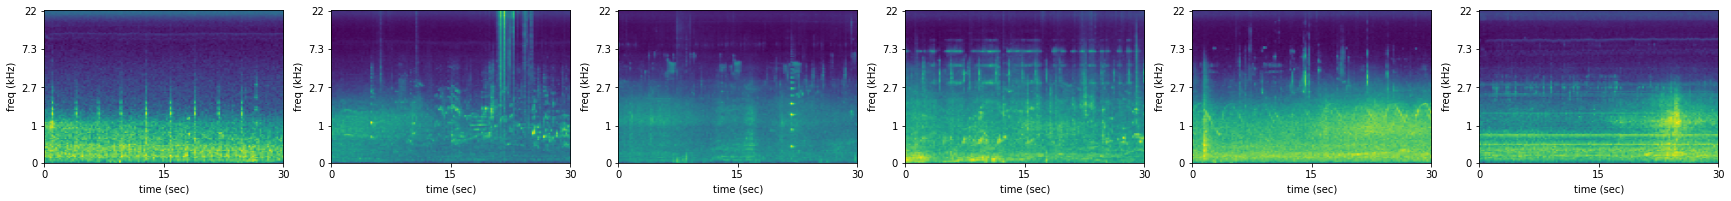

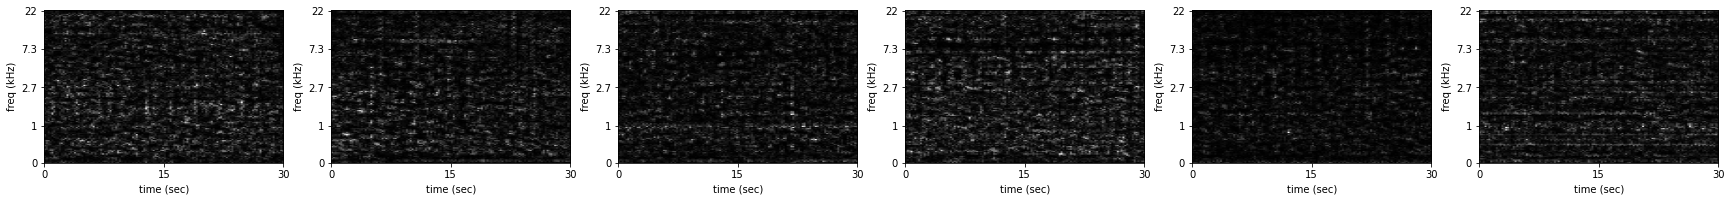

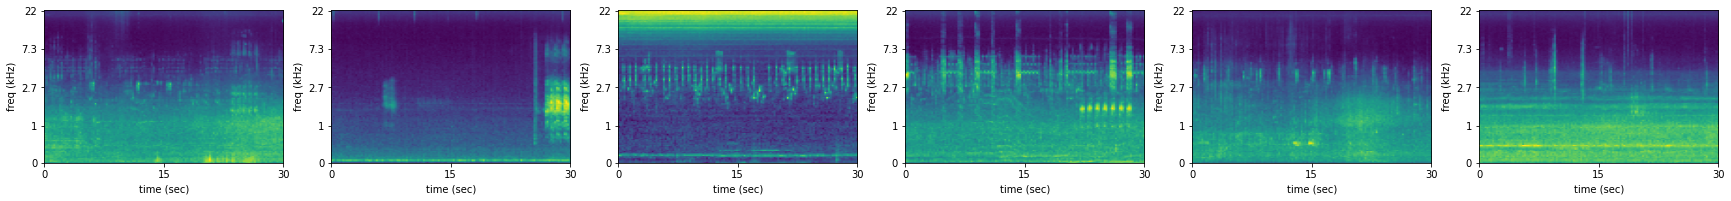

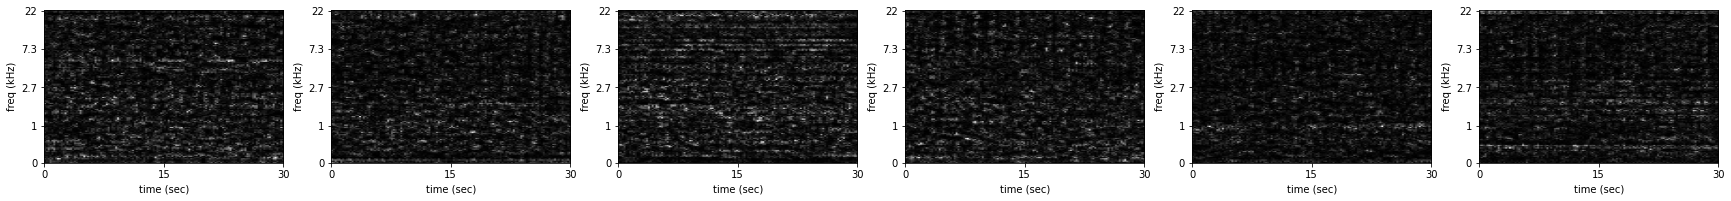

In [ ]:
%pdb off

import matplotlib.pyplot as plt

time_test = False

num_batches = 1

num_classes = 10

mono_model_name = "MonoCnnAudioNet"
mono_model = MonoCnnAudioNet(num_classes)
mono_model = loadModel(mono_model, mono_model_name, "Project/Models/Mono/")

model.eval()

for batch_idx, (dataBatch, target, extra_feature, file_name) in enumerate(training_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  dataBatch.requires_grad_()
  model.zero_grad()

  output = model(dataBatch, extra_feature)

  # # calculate the batch loss
  # if not time_test:
  #   loss = criterion(output,torch.max(target.long(), 1)[1])
  # else:
  #   loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
  # # backward pass: compute gradient of the loss with respect to model parameters
  # loss.backward()

  one_hot = torch.zeros(output.shape)
  one_hot[target.bool()] = 1
  if train_on_gpu:
    one_hot = one_hot.cuda()
  true_class_score = torch.sum(one_hot * output)

  true_class_score.backward()

  saliency_maps = dataBatch.grad.data.abs()

  plt.figure(figsize=(30, 30))
  for i_map in range(6): # dataBatch.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach().cpu()
      plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
      # plt.axis("off")
  plt.show()

  print('\n\n')

  plt.figure(figsize=(30, 30))
  for i_map in range(6): # saliency_maps.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      map = saliency_maps[i_map,...].squeeze().cpu()
      plt.imshow(map, cmap='gray', origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
    # plt.axis("off")
  plt.show()
  
  print('\n\n')



# SmoothGrad saliency maps

Automatic pdb calling has been turned OFF


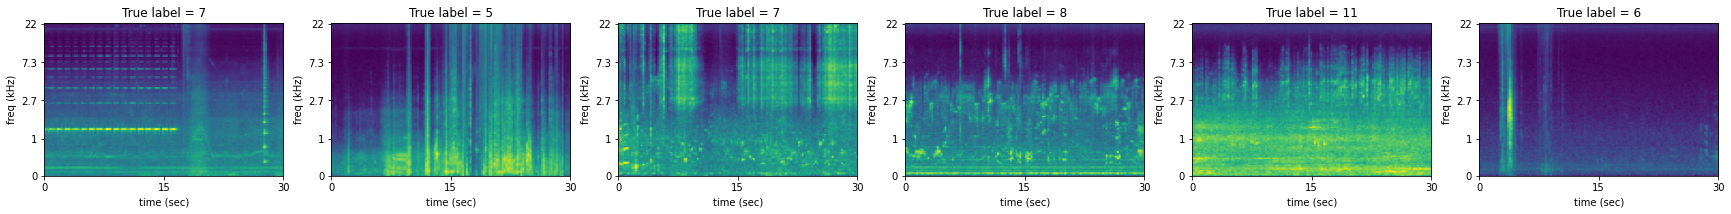

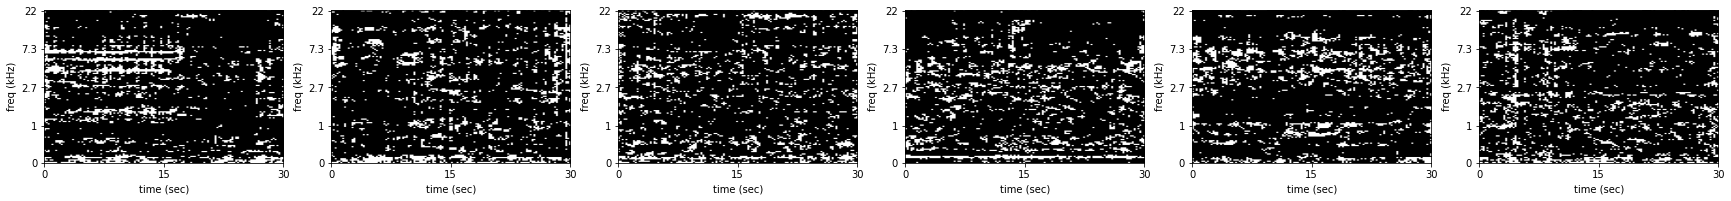

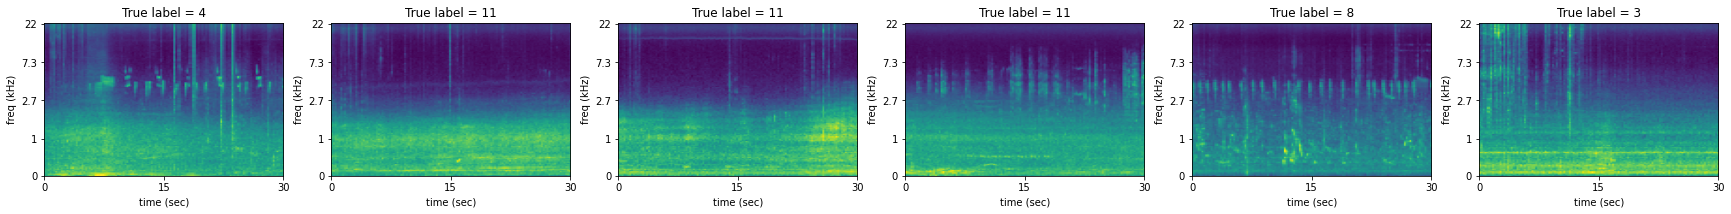

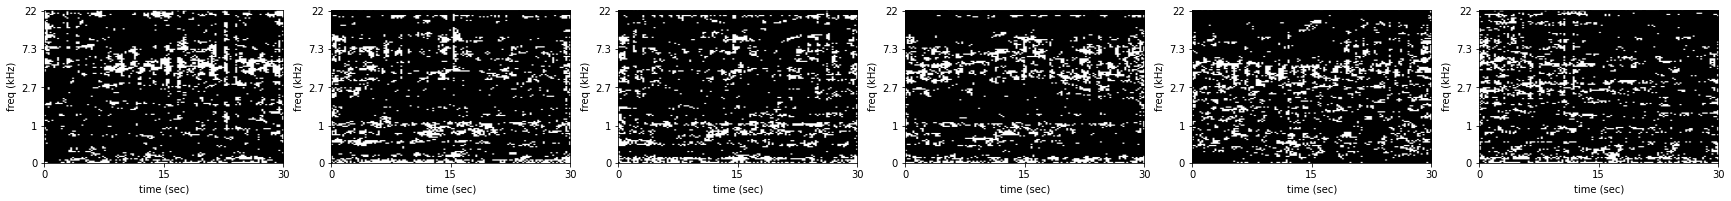

In [ ]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable

sigma_list = [0.1] # , 0.05] # 05
grad_mag_sqr = True
num_batches = 2
num_classes = 10
n_noise_samp = 30

eps = 1e-5

model_name = "MonoCnnAudioNet"
model = MonoCnnAudioNet(num_classes)
model = loadModel(model, model_name, "Project/Models/Mono/")

if(train_on_gpu): 
  model.cuda()

# if not time_test: 
#   criterion = nn.CrossEntropyLoss()
# else:
#   criterion = nn.MSELoss()

model.eval()

for batch_idx, (dataBatch, target, extra_feature, file_name) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  dataBatch = dataBatch.data.cpu().numpy()

  for sigma in sigma_list:

    total_gradients = np.zeros_like(dataBatch)

    for noise_idx in tqdm(range(n_noise_samp), total=n_noise_samp, leave=False):

      # Create and add noise to dataBatch per data point
      noise = np.random.normal(0, 1, dataBatch.shape).astype(np.float32)
      for idx in range(dataBatch.shape[0]):
        data_point = dataBatch[idx, ...]
        noise[idx, ...] *= sigma * data_point.std() # (np.max(data_point) - np.min(data_point))
      data_plus_noise = dataBatch + noise
      if train_on_gpu:
        data_plus_noise = torch.from_numpy(data_plus_noise).cuda()
      else:
        data_plus_noise = torch.from_numpy(data_plus_noise)
      data_plus_noise = Variable(data_plus_noise, requires_grad=True)

      # pass data through model
      output = model(data_plus_noise, extra_feature)

      # # calculate the batch loss
      # if not time_test:
      #   loss = criterion(output,torch.max(target.long(), 1)[1])
      # else:
      #   loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

      one_hot = torch.zeros(output.shape)
      one_hot[target.bool()] = 1
      true_class_score = torch.sum(one_hot * output)

      loss = true_class_score

      # zero input gradient before backprop
      if data_plus_noise.grad is not None:
        data_plus_noise.grad.data.zero_()

      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      input_grad = data_plus_noise.grad.data.cpu().numpy()

      if grad_mag_sqr:
        total_gradients += np.abs(input_grad)**2
      else:
        total_gradients += input_grad


    smooth_saliency_maps = total_gradients / n_noise_samp

    true_labels = target.squeeze().argmax(1) + 2

    plt.figure(figsize=(30, 30))
    for i_map in range(6): # dataBatch.shape[0]):
        plt.subplot(1, 6, i_map + 1)
        spectrogram = dataBatch[i_map,...].squeeze()
        plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
        plt.title(f"True label = {true_labels[i_map].item()}")
        plt.yticks(ytick_locs,freq_ticks)
        plt.xticks(xtick_locs,time_ticks)
        plt.xlabel('time (sec)')
        plt.ylabel('freq (kHz)')
        # plt.axis("off")
    plt.show()

    print('\n\n')

    plt.figure(figsize=(30, 30))
    for i_map in range(6): # saliency_maps.shape[0]):
        plt.subplot(1, 6, i_map + 1)
        map = smooth_saliency_maps[i_map,...].squeeze()
        map = (map - map.min())/(map.max() - map.min())
        map += eps

        mn_high = np.percentile(map, 15) # 30
        mn_low  = np.percentile(map, 0)  # 0
        indexes = (map<=mn_high) & (map>=mn_low)
        map[indexes]  = 1.0
        map[~indexes] = 0.0

        plt.imshow(map, cmap='gray', origin='lower', extent = adjusted_extent)
        plt.yticks(ytick_locs,freq_ticks)
        plt.xticks(xtick_locs,time_ticks)
        plt.xlabel('time (sec)')
        plt.ylabel('freq (kHz)')
        # plt.axis("off")
    plt.show()
    
    print('\n\n')

    # print("Class scores")
    # plt.figure(figsize=(30, 30/8))
    # for i_map in range(6): # first 8 in batch
    #     plt.subplot(1, 6, i_map + 1)
    #     scores = output[i_map,...].squeeze().detach().cpu()
    #     true_label = torch.nonzero(target[i_map].squeeze()).item()
    #     bar_colors = ['b']*10
    #     bar_colors[true_label] = 'r'
    #     plt.bar(np.arange(2,12),scores, color=bar_colors)
    #     plt.grid()
    #     plt.xticks(np.arange(2,12))
    #     plt.title(f'True label = {true_label+2}')
    #     # plt.axis("off")
    # plt.show()

    # print('\n\n\n\n')

# Other stuff

Evaluate model on validation set

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in valid_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
# import pdb; pdb.set_trace()
print('Validation accuracy: {}%'.format(accuracy * 100))

Evaluate model on test set

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
          
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

Evaluate model on training

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in training_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
        output = model(dataBatch, timestamp)
        outP = torch.sigmoid(output)
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        
accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Train accuracy: {}%'.format(accuracy * 100))

Plot confusion matrix

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    all_targets = torch.tensor([]).cuda()
    for batch in loader:
        images, labels, timestamp = batch
        images, labels, timestamp = images.unsqueeze(1).float().cuda(), labels.cuda(), timestamp.unsqueeze(1).cuda()#images.unsqueeze(1).float().cuda(), labels.cuda()
        preds = model(images, timestamp)
        preds = torch.nn.functional.softmax(preds)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat(
            (all_targets, labels)
            ,dim=0
        )
    return all_preds.cpu(), all_targets.cpu()

def confusion_matrix(real_targets, train_preds):
    stacked = torch.stack((real_targets,train_preds),dim=1)
    cmt = torch.zeros(num_classes,num_classes, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
import matplotlib.pyplot as plt

#from sklearn.metrics import confusion_matrix

with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, test_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
plt.figure(figsize=(num_classes,num_classes))
classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
plot_confusion_matrix(cm, classes)
    

Plot accuracy throughout the day

In [ ]:
epoch_num = 19
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/Mono/epochs/")
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
timestamp_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        timestamp_all.extend(timestamp.tolist())

array = (np.array(Label_all) == np.array(Output_all))
timestamp_all = np.array(timestamp_all)

plt.figure(figsize=(8, 10))
timestamp_false = timestamp_all[np.where(array==False)]
counts_false, bins_false = np.histogram(timestamp_false, bins=22)

timestamp_true = timestamp_all[np.where(array==True)]
counts_true, bins_true = np.histogram(timestamp_true, bins=22)
plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(bins_true[:-1], bins_true, weights=counts_true/(counts_true+counts_false))
plt.title('Accuracy over hour in day')
plt.tight_layout()

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

Save model weights for ensemble

In [ ]:
with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, valid_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
model_weights = torch.zeros(10)
for i in range(0,num_classes):
    model_weights[i] = cm[i][i]
model_acc = torch.sum(model_weights) / 10

print("model accuracy is", model_acc)
print("model weights are ", model_weights)
torch.save(model_acc, "/media/kfir/wiseData/Project/Models/Mono/accuracy.pt")
torch.save(model_weights, "/media/kfir/wiseData/Project/Models/Mono/weights.pt")
